In [2]:
'''
#Gigacow-tools# - data collection for fast/slow learner.
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#access data from local directory
dataDir = Path.cwd().parent.parent.parent/'Data/processed'
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'BirthDate']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir/'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir/'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir/'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

5613    12729
4478    11601
3757    11428
6197    11250
2423    11192
4504    10688
3147    10658
5147    10576
5046    10204
478     10028
Name: Gigacow_Cow_Id, dtype: int64


In [3]:
# Select cows with sufficient data points on single lactation periods
# Try to collect cow's data that contain milking events on lactation periods 1
# fetch all milking traffic events for merging
traffic_milking = traffic.TrafficResult.str.contains('kg', regex=False)
all_list = traffic_milking.index[traffic_milking.values == True].tolist()
milking_total = traffic[traffic.index.isin(all_list)]
milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date

# convert data type
milking_total.milking_date = pd.to_datetime(milking_total.milking_date)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
# merge all milking events with lactation table for filtering
milking_total = milking_total.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'milking_date'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])

def lac_collect(NumLac, milking_total):
    """Generate cow list for multiple lactation periods.

    Args:
        NumLac: The number of lactaion period
        milking_total: A dataframe contains all the milkings events

    Returns:
        A list contain all the cows events with sufficient data points within the lactation periods.
    """
    cow_list = list()
    for num in range(1, NumLac+1):
        # select records that contains lactation period #num
        milking_select1 = milking_total.loc[milking_total['LactationNumber'] == num]
        milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
        # drop the anomaly data point
        milking_select1 = milking_select1.loc[milking_select1.DaysInMilk < 400]
        # select sufficient data points on lactation 1
        selected1 = milking_select1.Gigacow_Cow_Id.value_counts(ascending=True)
        selected1 = selected1.loc[(selected1.values > 120) & (selected1.values < 365)]
        selected_cow_list = selected1.index.to_list()
        if num == 1:
            cow_list = selected_cow_list
        cow_list = list(set(cow_list) & set(selected_cow_list))
        print(len(cow_list), cow_list)
    return cow_list

cow_list = lac_collect(1, milking_total)

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\2005252543.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\2005252543.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\2005252543.py:11: SettingWithCopyWarning: 
A value is trying 

118 [2560, 3075, 2569, 4109, 3603, 1555, 5147, 3613, 544, 550, 5160, 2090, 3638, 3657, 74, 1103, 4176, 2135, 6235, 4704, 6241, 4195, 4200, 622, 5235, 3705, 3707, 645, 2694, 5767, 3718, 2702, 151, 6300, 4765, 1181, 3744, 2724, 1705, 6316, 3762, 5301, 182, 4280, 4792, 708, 4295, 5322, 2251, 1738, 1744, 5844, 5846, 4311, 5848, 6360, 1244, 5852, 2278, 2792, 6380, 5873, 2805, 5372, 1277, 769, 1796, 2844, 6434, 4899, 3890, 1336, 2374, 6472, 4939, 5965, 855, 5465, 1905, 3446, 3447, 2423, 4988, 4990, 385, 6018, 3979, 2956, 6039, 2460, 5534, 3487, 926, 2466, 2979, 4525, 943, 5555, 5046, 951, 4537, 961, 1985, 6086, 4038, 2510, 5076, 2517, 985, 478, 5088, 5092, 3563, 2031, 6127, 5616, 2039, 2047]


C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\2005252543.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)


In [4]:
@test - do not use this code chunk

# select records that contains lactation period 2
milking_select2 = milking_total.loc[milking_total['LactationNumber'] == 2]
milking_select2.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
# drop the anomaly data point
milking_select2 = milking_select2.loc[milking_select2.DaysInMilk < 400]
# select sufficient data points on lactation 2
selected2 = milking_select2.Gigacow_Cow_Id.value_counts(ascending=True)
selected2 = selected2.loc[(selected2.values > 100) & (selected2.values < 365)]
cow_list2 = selected2.index.to_list()
print(len(cow_list2), cow_list2)
cow_list_12 = list(set(cow_list) & set(cow_list2))
print(len(cow_list_12), cow_list_12)


91 [6405, 4008, 3638, 4544, 2031, 2354, 4848, 315, 3532, 6487, 5948, 1985, 1287, 3636, 2952, 1738, 574, 17, 1606, 4425, 5088, 3857, 5221, 5904, 5560, 3641, 3147, 5092, 1687, 4275, 1420, 910, 433, 6352, 4709, 562, 5848, 4906, 1103, 1624, 5183, 3792, 4316, 2382, 74, 3531, 80, 4257, 1348, 6351, 3674, 3121, 5211, 2000, 4074, 2946, 3127, 874, 636, 478, 5147, 6485, 1706, 1846, 3718, 2195, 5614, 5477, 560, 919, 926, 2712, 4220, 697, 129, 5470, 920, 849, 1181, 2237, 182, 6380, 1555, 5046, 2569, 6177, 90, 5613, 2423, 4825, 5442]
21 [3718, 2569, 1555, 2712, 5147, 1181, 926, 3638, 182, 5046, 1985, 74, 1738, 1103, 90, 478, 5088, 5092, 6380, 2031, 2423]


C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_31968\3352899061.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_select2.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)


In [4]:
def countCowAge(birthDate, milkingDate):
    '''
    func: Calculate cows age based on birthDate and milkingDate
    args: 
        birthDate: cow's birth datetime
        milkingDate: milking events datetime
    return: cow age in human years(float)
    '''
    birthDate = pd.to_datetime(birthDate)
    milkingDate = pd.to_datetime(milkingDate)
    days = np.float32(np.datetime64(milkingDate, 'D') - np.datetime64(birthDate, 'D'))
    age = np.around(days/365, 2)
    return age

In [5]:
# select single cow from the traffic table

def data_collector(traffic, gigacow, lactation, cow_id, lacNumList):
    '''
    func: collect features from for a single cow
    args: 
        traffic: traffic data table
        gigacow: gigacow data table
        lactation: lactation data table
        cow_id: gigacow_id of the cow
        lacNumList: a list lactation period number
    return: A dataframe contains all features for a single cow on specfic lactation period
    '''

    traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == cow_id]
    traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
    traffic_single_cow.index = range(len(traffic_single_cow))

    '''
        Extract Milking Event and its most recent traffic event to calculate T2-T1
        T1: Entry time into the Mjolkfalla
        T2: Entry time into the milking robot
        T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
    '''
    # locate mikling event by searching 'kg' keyword in traffic result
    # the most recent traffic event to milking event should be pre_milking event
    # need to filter out records with gate failure
    track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
    milking_index_list = track_milking.index[track_milking.values == True].tolist()
    pre_milking_index_list = [x-1 for x in milking_index_list]
    milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
    pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

    # drop rows that the gate failed to detect cows but have milking result
    # previous area in milking_traffic table should only be Mjolkfalla
    # previous area in pre_milking_traffic table should not be Mjolkfalla
    failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
    failed_list_1_pre = [x-1 for x in failed_list_1_milk]
    failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
    failed_list_2_milk = [x+1 for x in failed_list_2_pre]
    # traffic result in pre_milking_traffic table should contain Mjolkfalla
    track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
    failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
    failed_list_3_milk = [x+1 for x in failed_list_3_pre]

    # remove failed records based on index list
    milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
    pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
    milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
    pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
    # concatenate two tables to track the traffic directly
    all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
    all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
    #rename table columns for merging
    milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    # unify the index of two tables
    milking_traffic.index = range(len(milking_traffic))
    pre_milking_traffic.index = range(len(pre_milking_traffic))
    # inert "pre_traffic_milking" to milking traffic table
    milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
    # calculate T2-T1
    milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
    milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
    milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

    # extract traffic result(milk production)
    milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
    milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

    # merge all the other features into milking_traffic table
    milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
    milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
    lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
    single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
    single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'])

    # drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
    single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)
    single_cow_merge['TrafficDeviceName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)
    # calculate age of cows
    single_cow_merge['Age'] = single_cow_merge.apply(lambda x: countCowAge(x['BirthDate'], x['MilkingEventDateTime']), axis=1)
    single_cow_merge.drop(['BirthDate'], axis=1, inplace=True)
    single_cow_merge.dropna(inplace=True)

    # integrate multiple milking events for a single DIM
    single_cow_merge = single_cow_merge[single_cow_merge.LactationNumber.isin(lacNumList)]
    single_cow_merge.index = range(1,len(single_cow_merge)+1) 
    single_cow_merge.drop(['MilkingEventDateTime', 'Pre_MilkingEventDateTime', 'Traffic_Id', 'MilkingInterval_totalSeconds', 'RoundedSecondsTimeInArea', 'PreviousArea', 'GroupName', 'LactationInfoDate', 'TrafficDeviceName'], axis=1, inplace=True)

    comb_cows = single_cow_merge.groupby(by=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age'], sort=False, as_index=False).sum(['MilkProduction', 'timeDelta_Seconds'])
    single_cow_merge_size = single_cow_merge.groupby(by=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age'], sort=False, as_index=False).size()
    comb_cows = pd.concat([comb_cows, single_cow_merge_size['size']], axis=1, ignore_index=False)
    comb_cows.rename(columns={"MilkProduction": "Total_MilkProduction", "timeDelta_Seconds": "Total_timeDelta_Seconds", "size": "milking_times"}, inplace=True)
    comb_cows.index = range(1, len(comb_cows)+1)
    return comb_cows

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\208708011.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\208708011.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\208708011.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<Figure size 432x288 with 0 Axes>

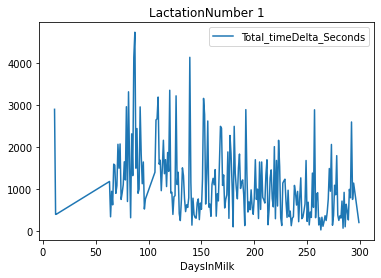

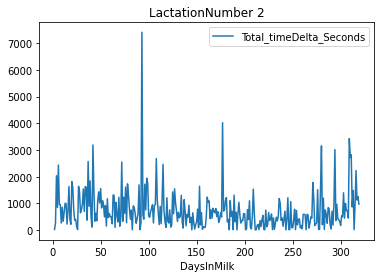

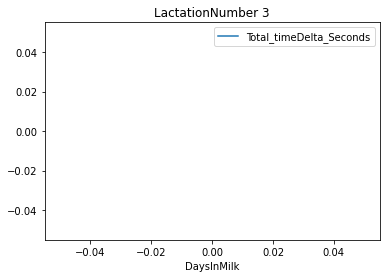

In [11]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
single_cow_merge = data_collector(traffic, gigacow, lactation, 2569, [1, 2])
plt.figure()
single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="Total_timeDelta_Seconds", kind='line', title='LactationNumber 1')
single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="Total_timeDelta_Seconds", kind='line', title='LactationNumber 2')
single_cow_merge.loc[single_cow_merge.LactationNumber == 3].plot(x="DaysInMilk", y="Total_timeDelta_Seconds", kind='line', title='LactationNumber 3')
plt.show()


In [14]:
single_cow_merge.Total_timeDelta_Seconds.mean()

1933.6423357664235

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\208708011.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\208708011.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\208708011.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<Figure size 432x288 with 0 Axes>

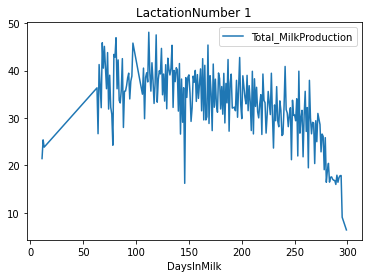

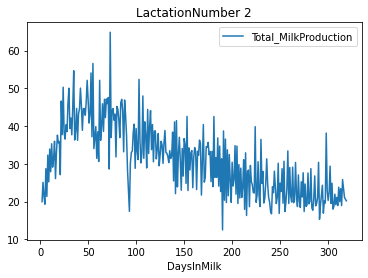

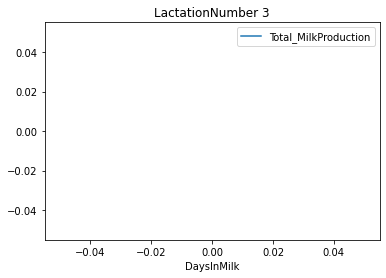

In [10]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
single_cow_merge = data_collector(traffic, gigacow, lactation, 2569, [1, 2])
plt.figure()
single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="Total_MilkProduction", kind='line', title='LactationNumber 1')
single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="Total_MilkProduction", kind='line', title='LactationNumber 2')
single_cow_merge.loc[single_cow_merge.LactationNumber == 3].plot(x="DaysInMilk", y="Total_MilkProduction", kind='line', title='LactationNumber 3')
plt.show()

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\208708011.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\208708011.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_66056\208708011.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<Figure size 432x288 with 0 Axes>

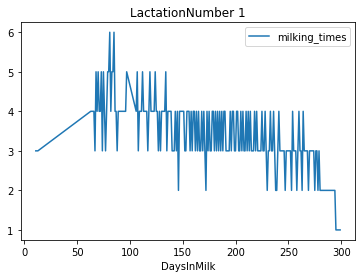

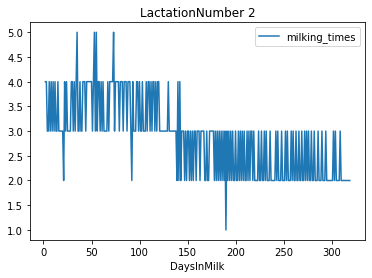

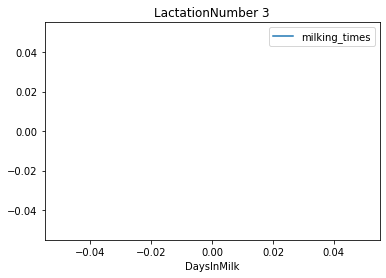

In [9]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
single_cow_merge = data_collector(traffic, gigacow, lactation, 2569, [1, 2])
plt.figure()
single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="milking_times", kind='line', title='LactationNumber 1')
single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="milking_times", kind='line', title='LactationNumber 2')
single_cow_merge.loc[single_cow_merge.LactationNumber == 3].plot(x="DaysInMilk", y="milking_times", kind='line', title='LactationNumber 3')
plt.show()

In [42]:
pd.options.mode.chained_assignment = None

In [12]:
threshold_time = 800

# labeling cow with good/bad learner(1/0)
def labeling_data(threshold_time, cow_total): 
    '''
    func: labeling learner dataset
    args: 
        threshold_time: threshold for milking time cost
        cow_total: A dataframe contains all data points for a single cow
    return: learner dataset with label
    '''
    global learner
    total_timeCost = cow_total.Total_timeDelta_Seconds.sum()
    totalEvents = cow_total.milking_times.sum()
    mean_timeCost = total_timeCost/totalEvents
    print(mean_timeCost)
    if mean_timeCost < threshold_time:
        learner = 1 # good learner
    else:
        learner = 0 # bad learner
    cow_total['label'] = learner
    return cow_total

In [16]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
single_cow_merge = data_collector(traffic, gigacow, lactation, 560, 1)
single_cow_merge = labeling_data(threshold_time, single_cow_merge)
single_cow_merge

832.6587030716723


,FarmName_Pseudo,Gigacow_Cow_Id,MilkingDate,LactationNumber,DaysInMilk,BreedName,Age,Total_MilkProduction,Total_timeDelta_Seconds,milking_times,label
1,a624fb9a,560,2020-01-31,1.0,21.0,1,2.33,31.71,2737.0,3,0
2,a624fb9a,560,2020-02-01,1.0,22.0,1,2.34,40.85,4738.0,4,0
3,a624fb9a,560,2020-02-02,1.0,23.0,1,2.34,32.72,5123.0,3,0
4,a624fb9a,560,2020-02-03,1.0,24.0,1,2.34,39.22,4915.0,4,0
5,a624fb9a,560,2020-02-04,1.0,25.0,1,2.35,38.82,7634.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...
91,a624fb9a,560,2020-12-23,1.0,348.0,1,3.23,22.44,1117.0,3,0
92,a624fb9a,560,2020-12-24,1.0,349.0,1,3.23,7.54,10.0,1,0
93,a624fb9a,560,2020-12-25,1.0,350.0,1,3.24,24.38,1024.0,2,0
94,a624fb9a,560,2020-12-26,1.0,351.0,1,3.24,9.42,1008.0,1,0


In [23]:
timeCost = single_cow_merge.Total_timeDelta_Seconds.sum()
totalEvents = single_cow_merge.milking_times.sum()
mean_time = timeCost/totalEvents
mean_time

905.3110328638497

In [28]:
timeCost/len(single_cow_merge)

2706.40350877193

In [21]:
single_cow_merge.Total_timeDelta_Seconds.mean()

2706.40350877193

In [15]:
pd.options.mode.chained_assignment = None

In [29]:
# 53 [1103, 1624, 5183, 3792, 4316, 2382, 74, 3531, 80, 4257, 1348, 6351, 3674, 3121, 5211, 2000, 4074, 2946, 3127, 874, 636, 478, 5147, 6485, 1706, 1846, 3718, 2195, 5614, 5477, 560, 919, 926, 2712, 4220, 697, 129, 5470, 920, 849, 1181, 2237, 182, 6380, 1555, 5046, 2569, 6177, 90, 5613, 2423, 4825, 5442]
# 13 [478, 3718, 2569, 74, 6380, 1103, 1555, 182, 5046, 5147, 1181, 926, 2423]

#cow_list_12 = [3718, 2569, 1555, 3603, 919, 2712, 5147, 1181, 926, 5160, 560, 5555, 3638, 182, 5046, 5948, 1985, 5442, 74, 1738, 1103, 6351, 5844, 6360, 5848, 90, 478, 5088, 5092, 2278, 6380, 2031, 2423, 3707]

mean_totalTimeCost = 0
Path(dataDir/'learner_targetCows').mkdir(parents=True, exist_ok=True)
lactationNum = 1

for i, cow_id in enumerate(cow_list_12):
    single_cow_merge = data_collector(traffic, gigacow, lactation, cow_id, lactationNum)
    mean_totalTimeCost += single_cow_merge.timeDelta_Seconds.mean()
    print(str(cow_id) + "\n" + str(single_cow_merge.timeDelta_Seconds.mean()))
    print(single_cow_merge.FarmName_Pseudo.unique())
    print(single_cow_merge.timeDelta_Seconds.describe())
    #if(single_cow_merge.timeDelta_Seconds.mean() < 900):
    #    print("good")
    single_cow_merge["id"] = i+1
    single_cow_merge.dropna(inplace=True)
    fileName = 'learner_targetCows/cow_' + str(i) + '.csv'
    
    single_cow_merge.to_csv(dataDir/fileName)
print("num of cows: ", len(cow_list_12))
print("Mean of total time cost: ", mean_totalTimeCost/len(cow_list_12))

3718
827.3369330453563
['a624fb9a']
count      926.000000
mean       827.336933
std       1095.307166
min          5.000000
25%         75.250000
50%        462.000000
75%       1069.250000
max      10943.000000
Name: timeDelta_Seconds, dtype: float64
2569
322.80102040816325
['a624fb9a']
count     784.000000
mean      322.801020
std       420.924669
min         3.000000
25%        29.500000
50%       211.000000
75%       403.250000
max      3621.000000
Name: timeDelta_Seconds, dtype: float64
1555
799.4668989547039
['a624fb9a']
count     574.000000
mean      799.466899
std      1113.289313
min         4.000000
25%       128.750000
50%       409.000000
75%       905.000000
max      9382.000000
Name: timeDelta_Seconds, dtype: float64
3603
1872.1141732283465
['f454e660']
count      254.000000
mean      1872.114173
std       2113.405421
min          5.000000
25%        378.250000
50%       1023.000000
75%       2776.750000
max      15061.000000
Name: timeDelta_Seconds, dtype: float64
919
14

In [29]:
pd.options.mode.chained_assignment = None

mean_totalTimeCost = 0
Path(dataDir/'learner_targetCows').mkdir(parents=True, exist_ok=True)
lactationNum = [1]

# save a list of cow data for learner problems 
for i, cow_id in enumerate(cow_list):
    single_cow_merge = data_collector(traffic, gigacow, lactation, cow_id, lactationNum)
    mean_totalTimeCost += single_cow_merge.Total_timeDelta_Seconds.mean()
    print(single_cow_merge.Total_timeDelta_Seconds.sum()/single_cow_merge.milking_times.sum())
    if(single_cow_merge.Total_timeDelta_Seconds.sum()/single_cow_merge.milking_times.sum() < 1500):
        print("good")
    single_cow_merge["id"] = i+1
    single_cow_merge.dropna(inplace=True)
    fileName = 'learner_targetCows/cow_' + str(i) + '.csv'
    
    single_cow_merge.to_csv(dataDir/fileName)
print("num of cows: ", len(cow_list))
print("Mean of total time cost: ", mean_totalTimeCost/len(cow_list))

768.3705234159779
good
2320.3986928104573
322.4289372599232
good
5703.807560137457
1819.822006472492
800.7993019197207
good
653.2897657213317
good
1020.9094650205761
good
4700.7307692307695
2622.257322175732
601.0283353010626
good
1081.7171532846714
good
1043.4575342465753
good
3049.2643051771115
669.6450331125828
good
603.2755102040817
good
1717.4320113314448
2231.5455861070914
7907.5353982300885
1809.4279835390946
1350.5035663338087
good
1155.2820512820513
good
1342.4238993710692
good
2777.0
983.3914835164835
good
699.6016260162602
good
911.9521410579345
good
3287.3688212927755
3597.572265625
1209.9851632047478
good
829.011917659805
good
366.36744186046514
good
670.6227678571429
good
3288.4358974358975
1481.3846153846155
good
1463.2184466019417
good
3276.7430555555557
3151.5974710221285
4237.080985915493
3239.5377128953774
3143.6022988505747
3679.2883642495785
1217.2872570194384
good
1629.117903930131
3208.3235908141965
684.8069948186528
good
4081.4811083123427
1320.938679245283
good